In [1]:
from IPython.display import Image
from qutip import *
import qutip.settings as qset
import latex
import pandas as pd
import time
import numpy as np
from scipy.interpolate import interp1d,CubicSpline
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import multiprocessing
import concurrent.futures
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from palettable.colorbrewer.qualitative import Set1_5

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": "15",
    "font.serif": ["Times New Roman"]})
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('legend', fontsize=13) 

In [38]:
# Parameters

kappa = 1.0 #cavity mode dissipation rate (this is why the parameters should be passed as arguments to the function func1)
Oc = 1.0*kappa #Rabi frequency 
delta = 0.5*kappa   # Delta_P
Nat = 1    
N = 12 #Fock space dimension
g = (20.0/np.sqrt(Nat))*kappa # List atom-field coupling strenght
EM = np.sqrt(1.0)*kappa #pump field strength
norm = 4*(EM/(kappa))**2 #normalization
#decay rates
G31 = 0.5*kappa  #atom
G32 = 0.5*kappa  #atom
#detunings
D1 = 0.0
D2 = 0.0
# time list
t_list = np.linspace(0, 2100, 1050)*kappa

In [39]:
# Field operator
op_list = []
for m in range(Nat+1):
    op_list.append(qeye(3))
op_list[0] = destroy(N)
a = tensor(op_list) 

# Atomic operators
S11_list = []
S22_list = []
S33_list = []
S13_list = []
S23_list = []
    
for n in range(Nat):
    op_list = []
    for m in range(Nat+1):
        op_list.append(qeye(3))

    op_list[0] = qeye(N)
        
    op_list[n+1] = basis(3,0)*basis(3,0).dag()
    S11_list.append(tensor(op_list))

    op_list[n+1] = basis(3,1)*basis(3,1).dag()
    S22_list.append(tensor(op_list))

    op_list[n+1] = basis(3,2)*basis(3,2).dag()
    S33_list.append(tensor(op_list))
        
    op_list[n+1] = basis(3,0)*basis(3,2).dag()
    S13_list.append(tensor(op_list))
        
    op_list[n+1] = basis(3,1)*basis(3,2).dag()
    S23_list.append(tensor(op_list))        
       
#total atomic operators
S11 = 0
S22 = 0
S33 = 0
S13 = 0
S23 = 0
    
for n in range(Nat):
    S11 = S11 + S11_list[n]
    S22 = S22 + S22_list[n]
    S33 = S33 + S33_list[n]
    S13 = S13 + S13_list[n]
    S23 = S23 + S23_list[n]


#Projectors (TALVEZ AQUI POSSA TER UM ERRO)

p1_list = []
p2_list = []
p3_list = []
p4_list = []
p5_list = []
for m in range(Nat+1):
    p1_list.append(qeye(3))
    p2_list.append(qeye(3))
    p3_list.append(qeye(3))
    p4_list.append(qeye(3))
    p5_list.append(qeye(3))
p1_list[0] = projection(N, 1, 1, offset = None)
p2_list[0] = projection(N, 2, 2, offset = None)
p3_list[0] = projection(N, 3, 3, offset = None)
p4_list[0] = projection(N, 4, 4, offset = None)
p5_list[0] = projection(N, 5, 5, offset = None)

p1 = 1 * tensor(p1_list)
p2 = 1 * tensor(p2_list)
p3 = 1 * tensor(p3_list)
p4 = 1 * tensor(p4_list)
p5 = 1 * tensor(p5_list)

In [40]:
# Hamiltonian

H = D1*S33 + (D1-D2)*S22 + delta*S11 - delta*a.dag()*a + (g*a*S13.dag() + Oc*S23.dag() + EM*a + g*a.dag()*S13 + Oc*S23 + EM*a.dag())

# Collapse operators

C = np.sqrt(kappa)*a   #cavity  
C31_list = []
C32_list = []
    
for n in range(Nat):
    C31_list.append(np.sqrt(G31)*S13_list[n])
    C32_list.append(np.sqrt(G32)*S23_list[n])
    
Clist = [C] + C31_list + C32_list

# Initial state

aux_list = []
for m in range(Nat+1):
    aux_list.append(basis(3,1))
aux_list[0] = basis(N,0)
psi0 = tensor(aux_list)

In [41]:
# Create empty lists

nc1_list = []      #Mean number of photon inside the cavity
nc2_list = []      #to calculate g2
n11_list = []       #Mean number of occupation in excited state |1>
n22_list = []       #Mean number of occupation in excited state |2>
n33_list = []       #Mean number of occupation in excited state |3>
g2_0_list = []     #Second-order correlation function 
p_1_list = []
p_2_list = []
p_3_list = []
p_4_list = []
p_5_list = []

# Parameters for MC (para o cluster mudar um pouco essa parte)

arg = [a.dag()*a, (a.dag()**2)*(a**2), S11, S22, S33, p1, p2, p3, p4, p5]

#data = mcsolve(H, psi0, t_list, Clist, arg, progress_bar=False, ntraj=1)

data = mesolve(H, psi0, t_list, Clist, arg, progress_bar=True)

nc1 = data.expect[0]/norm
nc1_m = np.mean(nc1[-100:])
nc2 = data.expect[1]/norm
nc2_m = np.mean(nc2[-100:])
    
g2_0 = nc2 / nc1 ** 2
    
# results lists
nc1_list.append(nc1)
n11_list.append(data.expect[2])
n22_list.append(data.expect[3])
n33_list.append(data.expect[4])
g2_0_list.append(g2_0)

p_1_list.append(data.expect[5])
p_2_list.append(data.expect[6])
p_3_list.append(data.expect[7])
p_4_list.append(data.expect[8])
p_5_list.append(data.expect[9])

# Saving

output_data = np.vstack((t_list, nc1_list, n11_list, n22_list, n33_list, g2_0_list, p_1_list, p_2_list, p_3_list, p_4_list, p_5_list))   
file_data_store('MeanNumberxt_Nat1_ep1_g20_Oc1_Dp05_ME.csv', output_data.T, numtype="real", numformat="decimal", sep= ",") 

/home/solakerino/miniconda3/lib/python3.12/site-packages/qutip/solver/solver_base.py:434: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


10.0%. Run time: 221.64s. Est. time left: 00:00:33:12
20.0%. Run time: 378.02s. Est. time left: 00:00:25:10
30.0%. Run time: 532.85s. Est. time left: 00:00:20:41
40.0%. Run time: 692.66s. Est. time left: 00:00:17:17
50.0%. Run time: 849.75s. Est. time left: 00:00:14:08
60.1%. Run time: 1008.40s. Est. time left: 00:00:11:10
70.1%. Run time: 1165.49s. Est. time left: 00:00:08:17
80.1%. Run time: 1320.99s. Est. time left: 00:00:05:28
90.1%. Run time: 1477.79s. Est. time left: 00:00:02:42
100.0%. Run time: 1632.18s. Est. time left: 00:00:00:00
Total run time: 1632.18s


/tmp/ipykernel_29212/3149938824.py:28: RuntimeWarning: invalid value encountered in divide
  g2_0 = nc2 / nc1 ** 2


/tmp/ipykernel_29212/335533914.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('Projectionsxt_Nat1_ep1_Oc1_Dp05_ME.png', format='png', dpi=600)
/home/solakerino/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


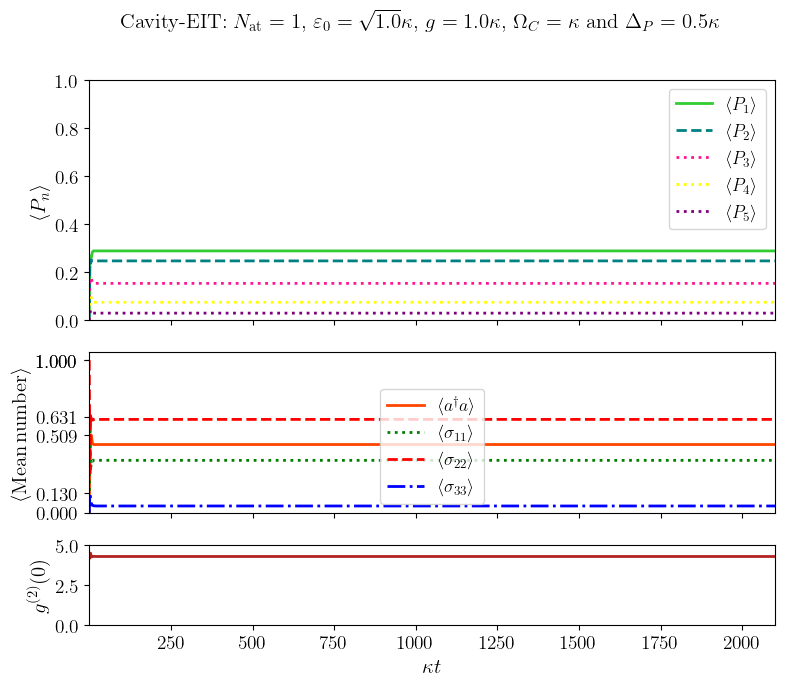

In [32]:
#Plot: epsilon=sqrt{1.0}*kappa, Nat=1 -> DYNAMICS: projections, mean number and correlation function

A1 = np.loadtxt(
    '/home/solakerino/Área de Trabalho/IC/results_cluster_backup/Código 3.0 (atual)/data/system_dynamics/Dynamics/MeanNumberxt_Nat1_ep1_g1_Oc1_Dp05_ME.csv', delimiter=',')


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(2.5*3.54,2.0*3.54),
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [12, 8, 4],
                       'wspace': 0.4,
                       'hspace': 0.2},tight_layout=True)

ax1.plot(A1[:,0], A1[:,6],color='limegreen',linestyle='solid',lw=2)
ax1.plot(A1[:,0], A1[:,7],color='teal',linestyle='dashed',lw=2)
ax1.plot(A1[:,0], A1[:,8],color='deeppink',linestyle='dotted',lw=2)
ax1.plot(A1[:,0], A1[:,9],color='yellow',linestyle='dotted',lw=2)
ax1.plot(A1[:,0], A1[:,10],color='purple',linestyle='dotted',lw=2)
ax1.set_ylabel(r'$\langle P_n \rangle$')
#ax1.set_xticks([0,5.0,10.0,15.0,20.0])
#ax1.set_yticks([0,max(A1[:,6]),max(A1[:,5]),max(A1[:,4])])
ax1.set_ylim([0,1.0])
ax1.legend([r'$\langle P_{1} \rangle$', r'$\langle P_{2} \rangle$', r'$\langle P_{3} \rangle$',  r'$\langle P_{4} \rangle$',  r'$\langle P_{5} \rangle$']) 
ax1.label_outer()


ax2.plot(A1[:,0], A1[:,1] ,color='orangered',linestyle='solid',lw=2)
ax2.plot(A1[:,0], A1[:,2] ,color='green',linestyle='dotted',lw=2)
ax2.plot(A1[:,0], A1[:,3] ,color='red',linestyle='dashed',lw=2)
ax2.plot(A1[:,0], A1[:,4] ,color='blue',linestyle='dashdot',lw=2)
ax2.set_ylabel(r'$\langle \mathrm{Mean \, number} \rangle$')
ax2.legend([r'$\langle a^\dagger a \rangle$', r'$\langle \sigma_{11}\rangle$',r'$\langle \sigma_{22}\rangle$',r'$\langle \sigma_{33}\rangle$']) 
ax2.set_yticks([0,max(A1[:,1]), max(A1[:,4]), max(A1[:,3]), max(A1[:,2]), 1.0])
ax2.set_ylim([0,1.05])
#ax2.set_xticks([0,5.0,10.0,15.0,20.0])
#ax2.set_xlim([0.05,10.0])
ax2.label_outer()

ax3.plot(A1[:,0], A1[:,5],color='firebrick',linestyle='solid',lw=2)
ax3.set_ylabel(r'$g^{(2)}(0)$')
#ax3.set_ylim([0.0,1.2*max(M2[:,12])])
ax3.set_xlim([0.001,2100])
#ax3.set_xticks([0,5.0,10.0,15.0,20.0])
#ax3.set_yticks([0,max(A1[:,5])])
ax3.set_xlabel(r'$\kappa t$')
ax3.set_ylim([0,5])


plt.suptitle(r'Cavity-EIT: $N_{\mathrm{at}}=1$, $\varepsilon_0=\sqrt{1.0}\kappa$, $g=1.0\kappa$, $\Omega_C=\kappa$ and $\Delta_P=0.5\kappa$', fontsize=15)
fig.savefig('Projectionsxt_Nat1_ep1_Oc1_Dp05_ME.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_29212/3411099838.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('Projectionsxt_Nat1_ep1_g10_Oc1_Dp05_ME.png', format='png', dpi=600)
/home/solakerino/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


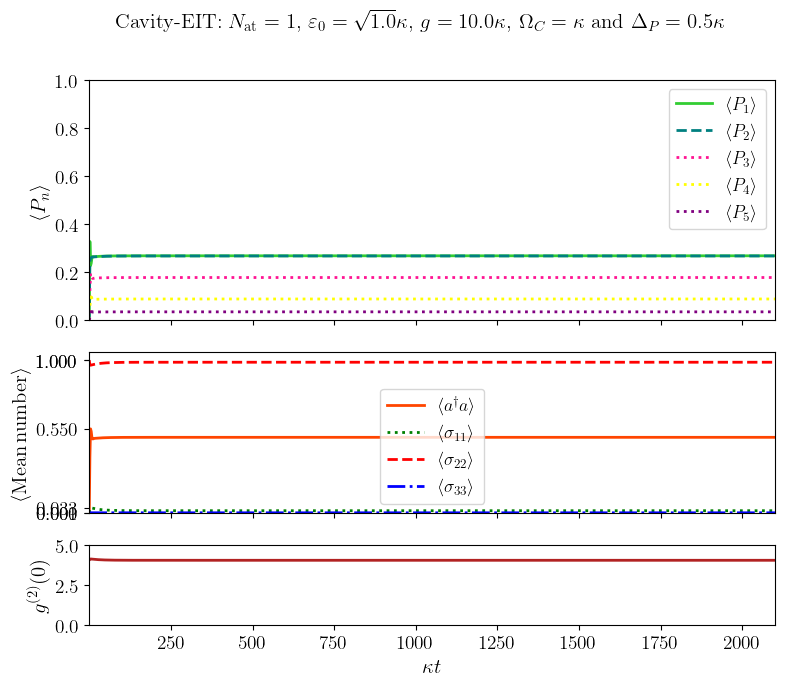

In [37]:
#Plot: epsilon=sqrt{1.0}*kappa, Nat=1 -> DYNAMICS: projections, mean number and correlation function

A1 = np.loadtxt(
    '/home/solakerino/Área de Trabalho/IC/results_cluster_backup/Código 3.0 (atual)/data/system_dynamics/Dynamics/MeanNumberxt_Nat1_ep1_g10_Oc1_Dp05_ME.csv', delimiter=',')


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(2.5*3.54,2.0*3.54),
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [12, 8, 4],
                       'wspace': 0.4,
                       'hspace': 0.2},tight_layout=True)

ax1.plot(A1[:,0], A1[:,6],color='limegreen',linestyle='solid',lw=2)
ax1.plot(A1[:,0], A1[:,7],color='teal',linestyle='dashed',lw=2)
ax1.plot(A1[:,0], A1[:,8],color='deeppink',linestyle='dotted',lw=2)
ax1.plot(A1[:,0], A1[:,9],color='yellow',linestyle='dotted',lw=2)
ax1.plot(A1[:,0], A1[:,10],color='purple',linestyle='dotted',lw=2)
ax1.set_ylabel(r'$\langle P_n \rangle$')
#ax1.set_xticks([0,5.0,10.0,15.0,20.0])
#ax1.set_yticks([0,max(A1[:,6]),max(A1[:,5]),max(A1[:,4])])
ax1.set_ylim([0,1.0])
ax1.legend([r'$\langle P_{1} \rangle$', r'$\langle P_{2} \rangle$', r'$\langle P_{3} \rangle$',  r'$\langle P_{4} \rangle$',  r'$\langle P_{5} \rangle$']) 
ax1.label_outer()


ax2.plot(A1[:,0], A1[:,1] ,color='orangered',linestyle='solid',lw=2)
ax2.plot(A1[:,0], A1[:,2] ,color='green',linestyle='dotted',lw=2)
ax2.plot(A1[:,0], A1[:,3] ,color='red',linestyle='dashed',lw=2)
ax2.plot(A1[:,0], A1[:,4] ,color='blue',linestyle='dashdot',lw=2)
ax2.set_ylabel(r'$\langle \mathrm{Mean \, number} \rangle$')
ax2.legend([r'$\langle a^\dagger a \rangle$', r'$\langle \sigma_{11}\rangle$',r'$\langle \sigma_{22}\rangle$',r'$\langle \sigma_{33}\rangle$']) 
ax2.set_yticks([0,max(A1[:,1]), max(A1[:,4]), max(A1[:,3]), max(A1[:,2]), 1.0])
ax2.set_ylim([0,1.05])
#ax2.set_xticks([0,5.0,10.0,15.0,20.0])
#ax2.set_xlim([0.05,10.0])
ax2.label_outer()

ax3.plot(A1[:,0], A1[:,5],color='firebrick',linestyle='solid',lw=2)
ax3.set_ylabel(r'$g^{(2)}(0)$')
#ax3.set_ylim([0.0,1.2*max(M2[:,12])])
ax3.set_xlim([0.001,2100])
#ax3.set_xticks([0,5.0,10.0,15.0,20.0])
#ax3.set_yticks([0,max(A1[:,5])])
ax3.set_xlabel(r'$\kappa t$')
ax3.set_ylim([0,5])


plt.suptitle(r'Cavity-EIT: $N_{\mathrm{at}}=1$, $\varepsilon_0=\sqrt{1.0}\kappa$, $g=10.0\kappa$, $\Omega_C=\kappa$ and $\Delta_P=0.5\kappa$', fontsize=15)
fig.savefig('Projectionsxt_Nat1_ep1_g10_Oc1_Dp05_ME.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_29212/685036856.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('Projectionsxt_Nat1_ep1_g20_Oc1_Dp05_ME.png', format='png', dpi=600)
/home/solakerino/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


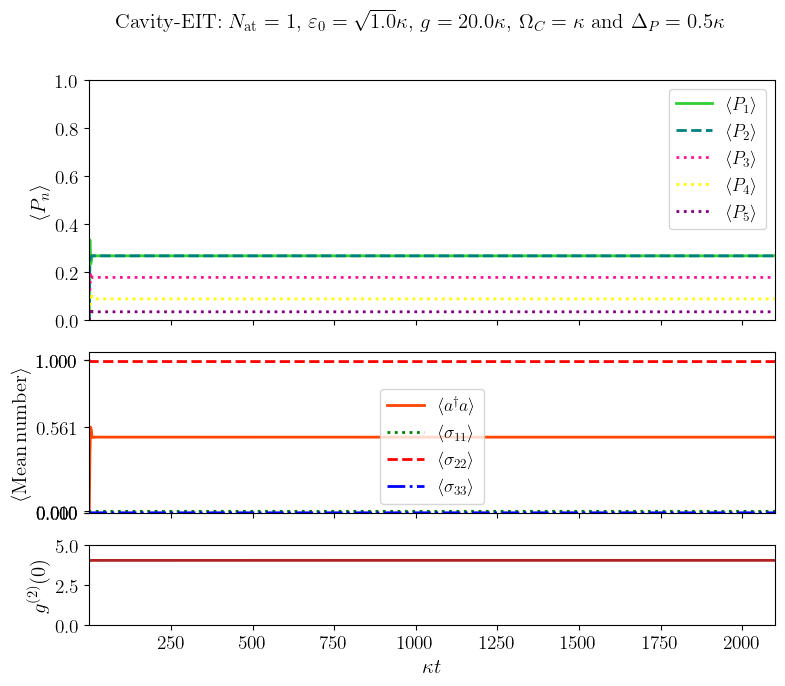

In [42]:
#Plot: epsilon=sqrt{1.0}*kappa, Nat=1 -> DYNAMICS: projections, mean number and correlation function

A1 = np.loadtxt(
    '/home/solakerino/Área de Trabalho/IC/results_cluster_backup/Código 3.0 (atual)/data/system_dynamics/Dynamics/MeanNumberxt_Nat1_ep1_g20_Oc1_Dp05_ME.csv', delimiter=',')


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(2.5*3.54,2.0*3.54),
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [12, 8, 4],
                       'wspace': 0.4,
                       'hspace': 0.2},tight_layout=True)

ax1.plot(A1[:,0], A1[:,6],color='limegreen',linestyle='solid',lw=2)
ax1.plot(A1[:,0], A1[:,7],color='teal',linestyle='dashed',lw=2)
ax1.plot(A1[:,0], A1[:,8],color='deeppink',linestyle='dotted',lw=2)
ax1.plot(A1[:,0], A1[:,9],color='yellow',linestyle='dotted',lw=2)
ax1.plot(A1[:,0], A1[:,10],color='purple',linestyle='dotted',lw=2)
ax1.set_ylabel(r'$\langle P_n \rangle$')
#ax1.set_xticks([0,5.0,10.0,15.0,20.0])
#ax1.set_yticks([0,max(A1[:,6]),max(A1[:,5]),max(A1[:,4])])
ax1.set_ylim([0,1.0])
ax1.legend([r'$\langle P_{1} \rangle$', r'$\langle P_{2} \rangle$', r'$\langle P_{3} \rangle$',  r'$\langle P_{4} \rangle$',  r'$\langle P_{5} \rangle$']) 
ax1.label_outer()


ax2.plot(A1[:,0], A1[:,1] ,color='orangered',linestyle='solid',lw=2)
ax2.plot(A1[:,0], A1[:,2] ,color='green',linestyle='dotted',lw=2)
ax2.plot(A1[:,0], A1[:,3] ,color='red',linestyle='dashed',lw=2)
ax2.plot(A1[:,0], A1[:,4] ,color='blue',linestyle='dashdot',lw=2)
ax2.set_ylabel(r'$\langle \mathrm{Mean \, number} \rangle$')
ax2.legend([r'$\langle a^\dagger a \rangle$', r'$\langle \sigma_{11}\rangle$',r'$\langle \sigma_{22}\rangle$',r'$\langle \sigma_{33}\rangle$']) 
ax2.set_yticks([0,max(A1[:,1]), max(A1[:,4]), max(A1[:,3]), max(A1[:,2]), 1.0])
ax2.set_ylim([0,1.05])
#ax2.set_xticks([0,5.0,10.0,15.0,20.0])
#ax2.set_xlim([0.05,10.0])
ax2.label_outer()

ax3.plot(A1[:,0], A1[:,5],color='firebrick',linestyle='solid',lw=2)
ax3.set_ylabel(r'$g^{(2)}(0)$')
#ax3.set_ylim([0.0,1.2*max(M2[:,12])])
ax3.set_xlim([0.001,2100])
#ax3.set_xticks([0,5.0,10.0,15.0,20.0])
#ax3.set_yticks([0,max(A1[:,5])])
ax3.set_xlabel(r'$\kappa t$')
ax3.set_ylim([0,5])


plt.suptitle(r'Cavity-EIT: $N_{\mathrm{at}}=1$, $\varepsilon_0=\sqrt{1.0}\kappa$, $g=20.0\kappa$, $\Omega_C=\kappa$ and $\Delta_P=0.5\kappa$', fontsize=15)
fig.savefig('Projectionsxt_Nat1_ep1_g20_Oc1_Dp05_ME.png', format='png', dpi=600)
plt.show()